In [1]:
import warnings

import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from deap import algorithms, base, creator, tools
import random
from baumeva import CollectorGA, generator
from baumeva.ga import BinaryPopulation, HyperbolaFitness, TournamentSelection, OnePointCrossover, \
    BinStringMutation, NewGeneration
from sklearn.model_selection import KFold

from PIL import Image
import imageio

RANDOM_STATE = 12345
keras.utils.set_random_seed(RANDOM_STATE)
generator.rnd_seed = RANDOM_STATE
random.seed(RANDOM_STATE)

data = pd.read_excel('БД ПКМ.xlsx', header=[0, 1])


name_columns = []
for i in range(len(data.columns)):
    if data.columns[i][1] != f'Unnamed: {i}_level_1':
        name_columns.append((data.columns[i][0] + ': ' + data.columns[i][1]).replace('\n', " "))
    else:
        name_columns.append((data.columns[i][0]).replace('\n', " "))
data.columns = name_columns
data.replace('-', None, inplace=True)


def filling_gaps(features, gaps):
    rfr_fill_gaps = RandomForestRegressor(n_estimators=5, max_depth=3, random_state=RANDOM_STATE)
    features_fill_gaps = data[features]
    target_fill_gaps = data[gaps]
    features_gaps = features_fill_gaps[target_fill_gaps.isna()]
    features_fill_gaps = features_fill_gaps[~target_fill_gaps.isna()]
    target_fill_gaps = target_fill_gaps[~target_fill_gaps.isna()]
    print("Features with gaps shape:", features_gaps.shape)
    print("Features without gaps shape:", features_fill_gaps.shape)
    print("Target with gaps shape:", target_fill_gaps.shape)
    rfr_fill_gaps.fit(features_fill_gaps, target_fill_gaps)
    print("Fitting completed.")
    predicted_values = rfr_fill_gaps.predict(features_gaps)
    print("Predicted values shape:", predicted_values.shape)
    filled_values = pd.Series(predicted_values, index=data[data[gaps].isna()].index).astype('int')
    print("Filled values shape:", filled_values.shape)
    data[gaps].fillna(filled_values, inplace=True)
    print("NaNs filled.")
    mse = mean_squared_error(target_fill_gaps, rfr_fill_gaps.predict(features_fill_gaps)) ** 0.5
    print("RMSE:", mse)



features = ['ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по основе, МПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по утку, МПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по основе, МПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по основе, МПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по утку, МПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль упругости при растяжении по утку, ГПа',
            'ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль межслоевого сдвига, МПа']
gaps = 'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по утку, МПа'
#filling_gaps(features, gaps)

features = ['ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Модуль упругости волокна при растяжении, ГПа',
            'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Относительное длинение при разрыве, %',
            'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Количество филаментов, тыс.шт.',
            'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Диаметр филаментов, мкм',
            'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Плотность, текс']
gaps = 'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Прочность при растяжении волокна, МПа'
filling_gaps(features, gaps)

gaps = 'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Разрывная нагрузка,   Н (кгс)'
filling_gaps(features, gaps)

data['ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Кол-во нитей основы/кол-во нитей утка на 1 cм'].fillna('Нет нитей утка', inplace=True)

list_of_columns = ['ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Прочность при растяжении волокна, МПа',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Разрывная нагрузка,     Н',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Прочность при растяжении волокна, МПа',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Удлинение на разрыв, %',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Количество филаментов, тыс.шт.',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Диаметр филаментов, мкм',
                   'ОСНОВНЫЕ СВОЙСТВА НИТИ (УТКА): Плотность, текс']
for i in list_of_columns:
    data[i].fillna(value=0, inplace=True)
data['НИТЬ (УТКА): Тип'].fillna('Нет нитей утка', inplace=True)
data.loc[data['ТКАНЬ: Вид плетения'] == 'Однонаправленная ', 'ТКАНЬ: Вид плетения'] = 'Однонаправленная'

data.dropna(axis=1, how='any', inplace=True)


object_columns = ['ПКМ', 'ТКАНЬ: Название', 'ТКАНЬ: Вид плетения',
                  'ТЕХНОЛОГИЯ ФОРМИРОВАНИЯ: Название',
                  'ТЕХНОЛОГИЯ ФОРМИРОВАНИЯ: Соотношение связующего к армирующему наполнителю',
                  'АРМИРУЮЩИЙ НАПОЛНИТЕЛЬ: Тип', 'ТКАНЬ: Название.1', 'ТКАНЬ: Вид плетения.1',
                  'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Кол-во нитей основы/кол-во нитей утка на 1 cм',
                  'НИТЬ (ОСНОВА): Название нити основы', 'НИТЬ (ОСНОВА): Тип',
                  'НИТЬ (УТКА): Тип', 'СВЯЗУЮЩЕЕ: Тип', 'Название']

pca = PCA(random_state=RANDOM_STATE)

num_columns = ['ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Разрывная нагрузка по основе, Н (кгс)',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Разрывная нагрузка по утку, Н (кгс)',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Прочность при растяжении по основе, МПа',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Прочность при растяжении по утку, МПа',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Модуль упругости при растяжении по основе, ГПа',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Модуль упругости при растяжении по утку, ГПа',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Удлинение на разрыв по основе, %',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Удлинение на разрыв по утку, %',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Поверхностная плотность, г/м2',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Толщина, мм',
               'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Прочность при растяжении волокна, МПа',
               'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Модуль упругости волокна при растяжении, ГПа',
               'ОСНОВНЫЕ СВОЙСТВА НИТИ (ОСНОВА): Относительное длинение при разрыве, %',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Прочность на растяжение, МПа',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Прочность на сжатие, МПа',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Прочность на изгиб, МПа',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Модуль упругости при растяжении, ГПа',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Усадка при отверждении, %',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: КЛТР, х10^-6, K^-1 ',
               'ОСНОВНЫЕ СВОЙСТВА СВЯЗУЮЩЕГО: Плотность, кг/м3', ]
obj_columns = ['ТЕХНОЛОГИЯ ФОРМИРОВАНИЯ: Название',
               'ТЕХНОЛОГИЯ ФОРМИРОВАНИЯ: Соотношение связующего к армирующему наполнителю',
               'ТКАНЬ: Вид плетения',
               'ОСНОВНЫЕ СВОЙСТВА ТКАНИ: Кол-во нитей основы/кол-во нитей утка на 1 cм',
               'НИТЬ (ОСНОВА): Тип', ]
target_columns = ['ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по основе, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по утку, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по основе, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по утку, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по основе, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по утку, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль упругости при растяжении по основе, ГПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль упругости при растяжении по утку, ГПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль межслоевого сдвига, МПа',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Относительное удлинение при разрыве по основе, %',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Относительное удлинение при разрыве по утку, %',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: ТКЛР по основе, х10^-6, K^-1 ',
                  'ОСНОВНЫЕ СВОЙСТВА ПКМ: Плотность, кг/м3', ]

obj_pip = Pipeline([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('input', SimpleImputer(strategy='most_frequent')),
])

feature_pip = Pipeline([
    ('coltrans', ColumnTransformer([
        ('num', StandardScaler(), num_columns),
        ('obj', obj_pip, obj_columns), ],
        remainder='passthrough', n_jobs=-1)),
    ('pca', PCA(random_state=RANDOM_STATE)),
])

new_features = data[num_columns + obj_columns]
feature_df = pd.DataFrame(feature_pip.fit_transform(new_features))
target_1 = data[target_columns]

kfold = KFold(5, shuffle=True, random_state=RANDOM_STATE)




Features with gaps shape: (1, 5)
Features without gaps shape: (41, 5)
Target with gaps shape: (41,)
Fitting completed.
Predicted values shape: (1,)
Filled values shape: (1,)
NaNs filled.
RMSE: 219.56781836825914
Features with gaps shape: (2, 5)
Features without gaps shape: (40, 5)
Target with gaps shape: (40,)
Fitting completed.
Predicted values shape: (2,)
Filled values shape: (2,)
NaNs filled.
RMSE: 141.50399529158693


In [ ]:
feature_df 

In [2]:
target_1

,"ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по основе, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на растяжение по утку, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по основе, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на сжатие по утку, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по основе, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Прочность на изгиб по утку, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль упругости при растяжении по основе, ГПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль упругости при растяжении по утку, ГПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Модуль межслоевого сдвига, МПа","ОСНОВНЫЕ СВОЙСТВА ПКМ: Относительное удлинение при разрыве по основе, %","ОСНОВНЫЕ СВОЙСТВА ПКМ: Относительное удлинение при разрыве по утку, %","ОСНОВНЫЕ СВОЙСТВА ПКМ: ТКЛР по основе, х10^-6, K^-1","ОСНОВНЫЕ СВОЙСТВА ПКМ: Плотность, кг/м3"
0,465.0,460,263,245.0,480,473,24,24.0,3700,4.5,4.5,8.0,2100
1,445.0,447,215,210.0,471,447,24,23.0,3440,4.6,4.7,8.0,1950
2,425.0,431,231,215.0,450,453,21,21.0,3428,4.5,4.5,8.0,1910
3,460.0,462,250,256.0,492,472,24,25.0,3807,4.5,4.6,8.0,2060
4,415.0,420,194,196.0,415,420,21,20.0,3810,4.7,4.7,8.0,1880
5,420.0,310,251,175.0,384,292,18,14.0,5100,5.6,5.7,9.0,1725
6,800.0,720,614,610.0,1100,1170,42,42.0,4950,2.0,2.0,2.2,1485
7,700.0,630,620,590.0,1050,1080,43,43.0,4950,2.1,2.1,2.2,1485
8,450.0,235,236,121.0,418,206,22,12.0,5700,5.4,5.5,9.0,2080
9,482.0,247,243,132.0,450,215,25,11.0,5800,5.4,5.4,9.0,2080


C:\Users\ivan\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\ivan\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

5  	50    	[[ 103.09970703  871.        ]
 [ 158.36347809  333.        ]
 [ 161.56912994  208.        ]
 [ 124.28438721  403.        ]
 [ 161.2282547   329.        ]
 [ 235.34064331   91.        ]
 [ 187.96189575  169.        ]
 [ 111.30891571  520.        ]
 [ 108.73890381 4589.        ]
 [ 110.8214592   871.        ]
 [ 158.79996185  345.        ]
 [ 172.83337555  208.        ]
 [ 129.24258118  442.        ]
 [ 129.90188446  403.        ]
 [ 164.96624146  333.        ]
 [ 237.450177     91.        ]
 [ 200.95391083  169.        ]
 [ 117.52431183  754.        ]
 [ 121.49114838  520.        ]
 [ 117.55189209  689.        ]
 [ 111.75862198  871.        ]
 [ 180.18615875  325.        ]
 [ 190.32164001  208.        ]
 [ 133.48967896  433.        ]
 [ 137.62573242  403.        ]
 [ 131.86793823  442.        ]
 [ 166.48552399  345.        ]
 [ 168.16738586  333.        ]
 [ 261.1618866    91.        ]
 [ 204.87110138  169.        ]
 [ 122.1276947   520.        ]
 [ 120.09144287  715.       

11 	50    	[[ 105.68143539  403.        ]
 [ 104.45657806  715.        ]
 [ 149.78517609  169.        ]
 [ 233.44365234   91.        ]
 [ 125.43593903  208.        ]
 [ 118.62508392  325.        ]
 [ 589.23198853   52.        ]
 [ 100.61180649  754.        ]
 [ 111.30891571  520.        ]
 [ 111.3875206   403.        ]
 [ 150.41239014  169.        ]
 [ 233.87884521   91.        ]
 [ 138.78177032  208.        ]
 [ 137.60456543  247.        ]
 [ 125.74308777  325.        ]
 [ 101.78499832  754.        ]
 [ 112.81097565  442.        ]
 [ 113.93993454  403.        ]
 [ 150.90384064  169.        ]
 [ 235.20238342   91.        ]
 [ 146.12203827  208.        ]
 [ 128.73393555  325.        ]
 [ 102.86784439  871.        ]
 [ 107.9015358   754.        ]
 [ 112.94634476  715.        ]
 [ 114.74574738  403.        ]
 [ 151.08503265  169.        ]
 [ 235.34064331   91.        ]
 [ 146.45475616  208.        ]
 [ 134.82062531  325.        ]
 [ 103.09970703  871.        ]
 [ 108.65943298  832.       

17 	50    	[[ 233.44365234   91.        ]
 [ 130.66507721  169.        ]
 [ 124.26906586  208.        ]
 [  98.91036911  715.        ]
 [ 109.80783234  325.        ]
 [ 102.5606041   403.        ]
 [ 317.83704834   52.        ]
 [ 233.46000366   91.        ]
 [ 131.21824341  169.        ]
 [ 125.43593903  208.        ]
 [  99.2867836   715.        ]
 [ 111.42664948  325.        ]
 [ 105.68143539  403.        ]
 [ 319.38344727   52.        ]
 [ 233.87884521   91.        ]
 [ 141.44485321  169.        ]
 [ 129.7780365   208.        ]
 [ 104.45657806  715.        ]
 [ 100.61180649  754.        ]
 [  99.7197319  1573.        ]
 [ 114.83611298  325.        ]
 [ 111.30891571  520.        ]
 [ 111.3875206   403.        ]
 [ 320.68475037   52.        ]
 [ 234.06871338   91.        ]
 [ 141.72780457  169.        ]
 [ 131.60048218  208.        ]
 [ 109.10091019  715.        ]
 [ 101.78499832  754.        ]
 [ 100.86439362 1573.        ]
 [ 114.8713974   325.        ]
 [ 112.73772812  442.       

23 	50    	[[ 233.44365234   91.        ]
 [ 130.66507721  169.        ]
 [  98.91036911  715.        ]
 [ 102.5606041   403.        ]
 [ 117.70534821  208.        ]
 [  98.66422882 1573.        ]
 [ 106.89152374  325.        ]
 [ 311.53278809   52.        ]
 [ 233.46000366   91.        ]
 [ 131.21824341  169.        ]
 [  99.2867836   715.        ]
 [ 105.43725739  403.        ]
 [ 122.82430115  208.        ]
 [ 109.80783234  325.        ]
 [ 312.30140991   52.        ]
 [ 233.87884521   91.        ]
 [ 138.66557617  169.        ]
 [ 104.45657806  715.        ]
 [ 100.61180649  754.        ]
 [  99.7197319  1573.        ]
 [ 105.68143539  403.        ]
 [ 124.26906586  208.        ]
 [ 111.42664948  325.        ]
 [ 312.93878784   52.        ]
 [ 234.06871338   91.        ]
 [ 138.8523819   169.        ]
 [ 101.78499832  754.        ]
 [ 100.86439362 1573.        ]
 [ 107.61086349  442.        ]
 [ 110.69131622  403.        ]
 [ 124.54146423  208.        ]
 [ 114.83611298  325.       

29 	50    	[[ 130.66507721  169.        ]
 [  98.91036911  715.        ]
 [ 117.70534821  208.        ]
 [ 311.53278809   52.        ]
 [ 229.97038879   91.        ]
 [  98.3037323  1573.        ]
 [ 100.92602234  325.        ]
 [ 131.21824341  169.        ]
 [  99.2867836   715.        ]
 [ 118.64956055  208.        ]
 [ 312.30140991   52.        ]
 [ 231.74858398   91.        ]
 [  98.66422882 1573.        ]
 [ 102.5606041   403.        ]
 [ 106.89152374  325.        ]
 [ 138.66557617  169.        ]
 [ 100.61180649  754.        ]
 [ 122.82430115  208.        ]
 [ 312.93878784   52.        ]
 [ 232.25601501   91.        ]
 [  99.7197319  1573.        ]
 [ 105.1397728   403.        ]
 [ 104.45657806  715.        ]
 [ 109.80783234  325.        ]
 [ 138.8523819   169.        ]
 [ 101.78499832  754.        ]
 [ 124.26906586  208.        ]
 [ 313.87282715   52.        ]
 [ 233.44365234   91.        ]
 [ 100.86439362 1573.        ]
 [ 105.43725739  403.        ]
 [ 105.41898575  715.       

NameError: name 'pth' is not defined

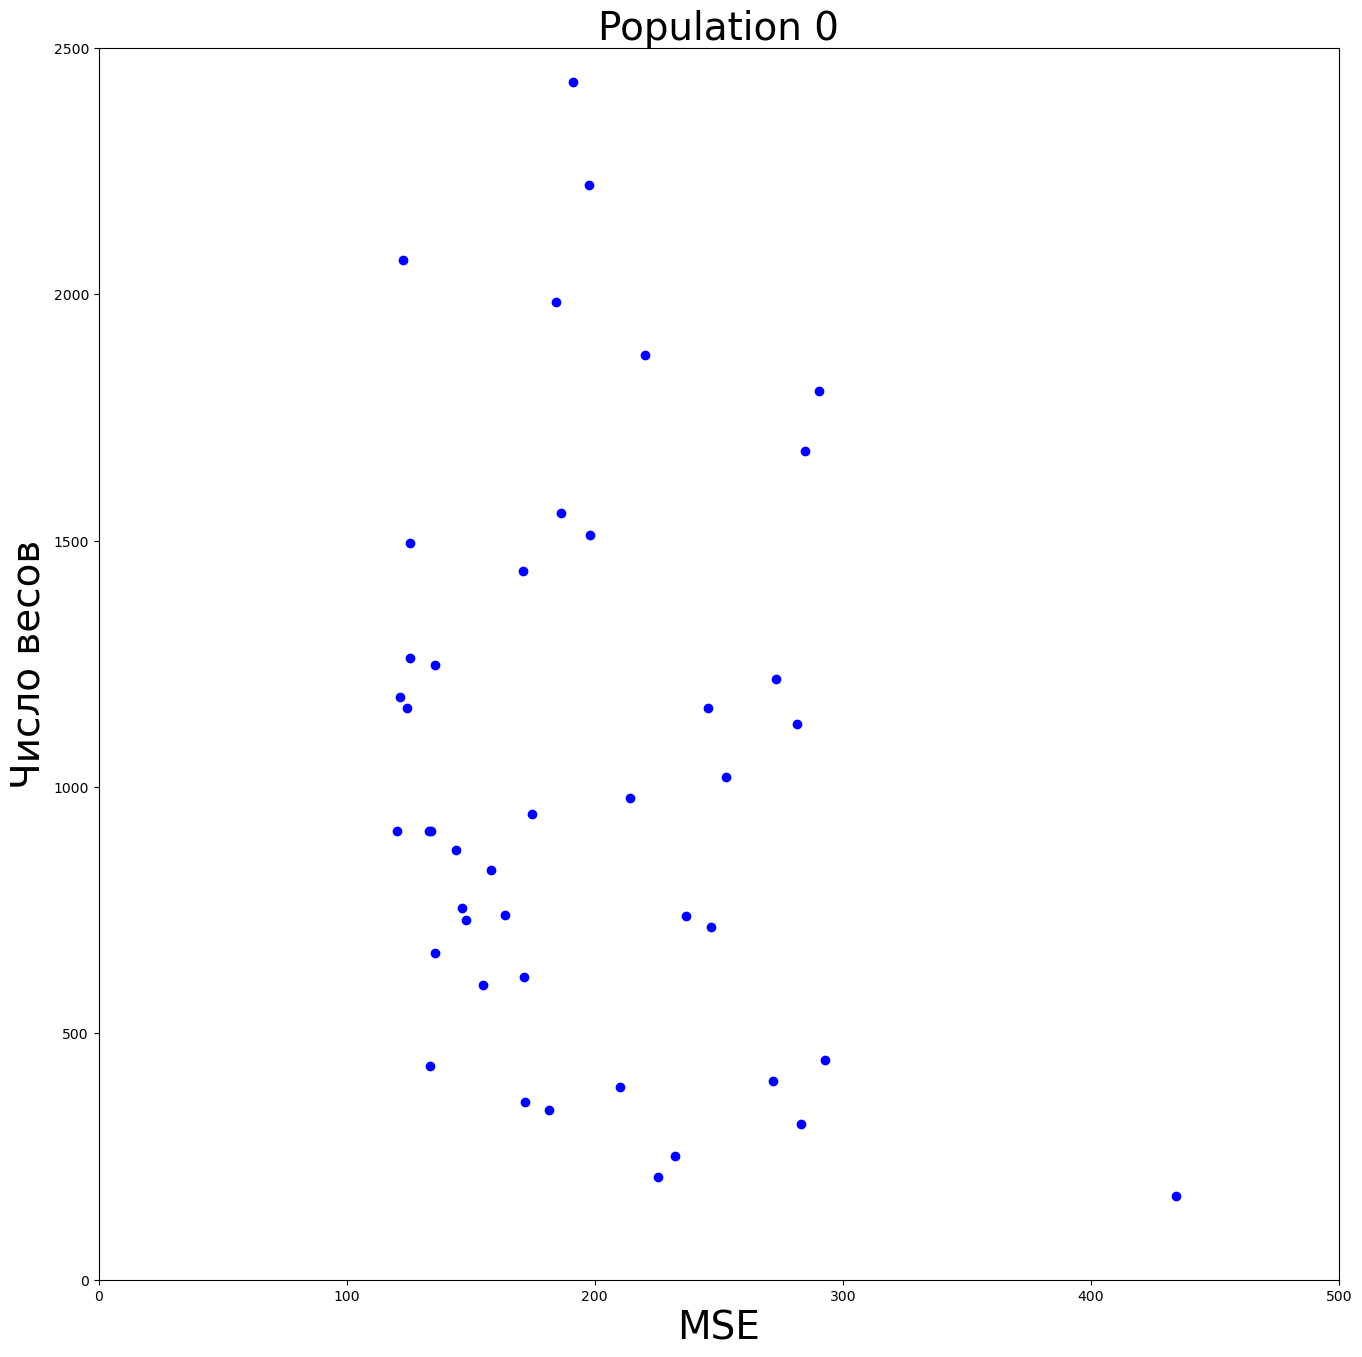

In [8]:
######################################################################      Models      #####################################################################################
def create_network(individual):
    model = keras.Sequential()
    # model.add(keras.layers.Normalization())
    if individual[-1] > MAX_NUM_OF_LAYERS:
        individual[-1] = MAX_NUM_OF_LAYERS
    for i in range(individual[-1]):
        model.add(keras.layers.Dense(int(individual[i]), activation='leaky_relu', ))
    model.add(keras.layers.Dense(units=13))
    return model


def fitting_model(model, feature, target):
    score_list = []
    for train, test in kfold.split(feature, target):
        model.fit(feature.iloc[train, :], target.iloc[train, :], epochs=EPOCHES, verbose=0)
        scores = model.evaluate(feature.iloc[test, :], target.iloc[test, :], verbose=0)
        score_list.append(scores[1])
    num_params = model.count_params()
    return (sum(score_list) / len(score_list)), num_params


def evaluate_network(individual):
    # На случай мутации
    if individual[-2] >= 1:
        individual[-2] = individual[-2] / 100
    model = create_network(individual)
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=individual[-2]),
                  metrics=[keras.metrics.RootMeanSquaredError()])
    loss, num_params = fitting_model(model, feature_df, target_1)
    # print('loss= ', loss, '| num_params= ', num_params)
    # print('individ: ', individual)
    return loss, num_params,

######################################################################      NSGA II      #####################################################################################

POPULATION_SIZE = 50  # размер популяции
PROBABILITY_OF_CROSSOVER = 0.7  # вероятность скрещивания
PROBABILITY_OF_MUTATION = 0.3  # вероятность мутации
GENERATIONS = 30  # количество поколений
EPOCHES = 10  # количество эпох при обучении нейросети
MIN_AMOUNT_OF_NEURONS = 1  # минимальное число нейронов в одном слое
MAX_AMOUNT_OF_NEURONS = 32  # максимальное число нейронов в одном слое
MIN_LEARNING_RATE = 0.05  # минимальный шаг обучения
MAX_LEARNING_RATE = 0.2  # максимальный шаг обучения
MAX_NUM_OF_LAYERS = 5  # максимальное число слоёв нейросети
MODEL = evaluate_network  # тип модели
OPTIMAZER = 'NSGA-II'  # тип оптимизатора ['NSGA-II', 'baumeva']
SELECT = tools.selNSGA2 # [tools.selNSGA2, tools.selSPEA2]

# Создаём функцию пригодности индивидов
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)


# Регистрируем функцию для генерации случайных чисел с плавающей запятой
def generate_float(a, b):
    return round(random.uniform(a, b), 3)  # Генерация float от 0.05 до 0.2


def My_initCycle(container, func, seq_func, n=1):
    f = container(func() for _ in range(n))
    for n_func in seq_func:
        f.append(n_func())
    return f

toolbox = base.Toolbox()
if 'evaluate_network' in str(MODEL):
    toolbox.register("num_layers_int", random.randint, 1,
                     MAX_NUM_OF_LAYERS)  # Генерация целого числа от 1 до 5
    toolbox.register("attr_int", random.randint, MIN_AMOUNT_OF_NEURONS,
                     MAX_AMOUNT_OF_NEURONS)  # Генерация целого числа от 0 до 32
    toolbox.register("attr_float", generate_float, MIN_LEARNING_RATE, MAX_LEARNING_RATE)
    # Регистрируем функцию для создания индивида, который будет содержать n целых чисел и одно число с плавающей запятой
    toolbox.register("individual", My_initCycle, container=creator.Individual, func=toolbox.attr_int,
                     seq_func=(toolbox.attr_float, toolbox.num_layers_int), n=MAX_NUM_OF_LAYERS)
elif 'MultiTaskLasso' in str(MODEL):
    toolbox.register('fit_intercept', random.choices([True, False]))
    toolbox.register('max_iter', random.randint, 1000, 5000)
    toolbox.register("tol", random.randint, 0.0001, 0.001)
    toolbox.register("individual", tools.initRepeat, creator.Individual, (toolbox.fit_intercept, toolbox.fit_intercept, toolbox.max_iter, toolbox.tol, toolbox.fit_intercept))

# Регистрируем функцию для генерации популяции tools.initRepeat(<контейнер>, <функция генерации>, <число>)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Создаем начальную популяцию
population = toolbox.population(n=POPULATION_SIZE)
# Регистрируем функцию оценки
toolbox.register("evaluate", MODEL)
# Регистрируем операторы для скрещивания и мутации
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=MAX_AMOUNT_OF_NEURONS * 2, indpb=PROBABILITY_OF_MUTATION)
# Регистрируем оператор для выбора
toolbox.register("select", SELECT)
# Cоздадим экземпляр специального класса Statistics() и в качестве аргумента передадим ссылку на функцию (в данном случае лямбда-функцию), которая укажет возвращаемую информацию для каждого конкретного индивидуума популяции
stats = tools.Statistics(lambda ind: ind.fitness.values)
# В экземпляре этого класса зарегистрируем статистику особей популяции на каждой итерации работы алгоритма:
stats.register('values', np.array)
# Запускаем оптимизацию NSGA-II
if OPTIMAZER == 'NSGA-II':
    final_population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=POPULATION_SIZE,
                                                          lambda_=POPULATION_SIZE,
                                                          cxpb=PROBABILITY_OF_CROSSOVER, mutpb=PROBABILITY_OF_MUTATION,
                                                          ngen=GENERATIONS, stats=stats,
                                                          verbose=True)
    vals = logbook.select("values")

    # Получаем все недоминируемые решения из популяции

    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

    print('vals= ', '\n', vals, '\n')
    print('pareto_front= ', '\n', pareto_front, '\n')
    print('pareto_front_vals= ', '\n', *zip(*[ind.fitness.values for ind in pareto_front]), '\n')


    def creat_frame(t):
        fig = plt.figure(figsize=(16, 16))
        for i in range(t):
            plt.plot(vals[i][:, 0], vals[i][:, 1], color='black', marker='o', linestyle='')
        if t == GENERATIONS:
            plt.plot(*zip(*[ind.fitness.values for ind in pareto_front]), 'ro', linestyle='')
            plt.title(f'Pareto Front', fontsize=28)
        else:
            plt.plot(vals[t][:, 0], vals[t][:, 1], 'bo', linestyle='')
            plt.title(f'Population {t}', fontsize=28)
        plt.ylim(0, 2500)
        plt.ylabel('Число весов', fontsize=28)
        plt.xlim(0, 500)
        plt.xlabel('MSE', fontsize=28)
        plt.savefig((pth + f'img/img_{t}.png'),
                    transparent=False,
                    facecolor='white'
                    )
        plt.close()


    for t in range(GENERATIONS + 1):
        creat_frame(t)

    frames = []
    for frame_number in range(GENERATIONS + 1):
        frame = Image.open(pth + f'img/img_{frame_number}.png')
        frames.append(frame)

    imageio.mimsave((pth + 'img/example.gif'), frames, fps=1, loop=0)


# Построение графика
# plt.figure(figsize=(8, 6))
# # plt.scatter(fitnesses[:, 0], fitnesses[:, 1], c='b', label='All Solutions')
# for v in vals:
#     plt.scatter(v[:, 0], v[:, 1], c='b')
# plt.scatter(*zip(*[ind.fitness.values for ind in pareto_front]), c='r', marker='o', label='Pareto Front')
# plt.xlabel('MSE mertics')
# plt.xlim(0, 1000)
# plt.ylabel('Amound of weights')
# plt.title('Pareto Front Visualization')
# plt.grid(True)
# plt.legend()
# plt.show()

# Интерактивый граффик
# plt.ion()
# for v in vals:
#     plt.scatter(v[:, 0], v[:, 1], c='b')
#     plt.draw()
#     plt.gcf().canvas.flush_events()
#
#     time.sleep(0.5)
# plt.ioff()
# plt.show()



In [ ]:
######################################################################     baumeva     #####################################################################################

def evaluate_network_baumeva(individual):
    individual.append(len(individual) - 1)
    model = create_network(individual)
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=individual[-2]),
                  metrics=[keras.metrics.RootMeanSquaredError()])
    loss, num_params = fitting_model(model, feature_df, target_1)
    print('loss= ', loss, '| num_params= ', num_params)
    print('individ: ', individual)
    return loss


# from baumeva import BinaryGA
#
# binary_ga = BinaryGA(num_generations=30,
#                      num_individ=10,
#                      gens=((1, 32, 1), (1, 32, 1), (1, 32, 1),(0.01, 0.16, 0.01)),
#                      obj_function=evaluate_network_baumeva,
#                      obj_value=0,
#                      is_gray=True,
#                      mutation_lvl="normal",
#                      early_stop=None)
# ga_data = binary_ga.optimize()

history = []


def generate_gens_params(one_gen: list, float_gen: list, num_layers: int) -> list:
    gens_params = []
    for _ in range(num_layers):
        gens_params.append(one_gen)
    gens_params.append(float_gen)
    return gens_params


def neurons(individual):
    my_ga = CollectorGA(fitness=HyperbolaFitness(obj_function=evaluate_network_baumeva, obj_value=0),
                        selection=TournamentSelection(),
                        crossover=OnePointCrossover(),
                        mutation=BinStringMutation(PROBABILITY_OF_MUTATION),
                        new_generation=NewGeneration('best'))

    my_ga.set_population(population=BinaryPopulation,
                         num_individ=POPULATION_SIZE,
                         num_generations=GENERATIONS,
                         gens=(generate_gens_params([MIN_AMOUNT_OF_NEURONS, MAX_AMOUNT_OF_NEURONS, 1],
                                                    [MIN_LEARNING_RATE, MAX_LEARNING_RATE, 0.01], individual)),
                         early_stop=200)

    my_ga.optimize()
    print("Лучшее решение", my_ga.ga_data.best_solution)
    history.append(my_ga.ga_data.historical_best)
    return my_ga.ga_data.best_solution['obj_score'], my_ga.ga_data.best_solution['phenotype']


if OPTIMAZER == 'baumeva':
    score = []
    for i in range(1, MAX_NUM_OF_LAYERS):
        score.append(neurons(i))
    print(score)

    print(history)

#################################################################################################
from sklearn.linear_model import MultiTaskLasso
from sklearn.metrics import root_mean_squared_error

MTL_model = MultiTaskLasso(random_state=RANDOM_STATE)
score_list = []
for train, test in kfold.split(feature_df, target_1):
    MTL_model.fit(feature_df.iloc[train, :], target_1.iloc[train, :])
    scores = root_mean_squared_error(target_1.iloc[test, :], MTL_model.predict(feature_df.iloc[test, :]))
    score_list.append(scores)

print(score_list)
print(sum(score_list) / len(score_list))
